In [1]:
import pandas as pd
import numpy as np
import gc
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from tqdm.notebook import tqdm
import lightgbm as lgb

### Used datatable jay file format to handle the large csv

In [2]:
! pip install datatable
import datatable as dt

In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)

## Build up from Questions.csv
### Merged with Train to build 'answered_correctly_content' => groupby('userid')

In [ ]:
results_c_r2 = pd.read_csv('results_c_r3.csv')

In [11]:
results_c_r3 = pd.concat([results_c_r2.drop('part', axis=1), pd.get_dummies(results_c_r2['part'])], axis=1)

In [12]:
results_c_r3 = results_c_r3.rename(columns={1: 'part_1', 2:'part_2', 3:'part_3', 4:'part_4', 5:'part_5', 6:'part_6', 7:'part_7'})

In [13]:
results_c_r3.columns

Index(['answered_correctly_content', 'content_sum', 'content_skew',
       'content_std', 'content_id', 'tags', 'tagsA', 'tagsB', 'tagsC',
       'diff_pass_rate', 'diff_pass_rate1', 'part_1', 'part_2', 'part_3',
       'part_4', 'part_5', 'part_6', 'part_7'],
      dtype='object')

# Feature engineering

In [61]:
## Previous dataset I built that has the mean elapsed time for each task_container_id (question bundle)
## by the top 80th percentile users by total correct
train_elapse_df = pd.read_csv('train_elapse_df.csv') 

## Build train.jay & valid.jay

In [ ]:
#### user performance within train
train['answered_correctly_sum_u'] = train.groupby('user_id')['answered_correctly'].cumsum()
train['count_u'] = train.groupby('user_id')['answered_correctly'].rank(method='first')
train['answered_correctly_avg_u'] = train['answered_correctly_sum_u'] / train['count_u']

In [ ]:
#### user performance merge to valid dataset for final feature
combo = pd.merge(train[['user_id', 'answered_correctly']], valid[['user_id', 'answered_correctly']], how='outer').drop_duplicates()
final_user_performance = combo.groupby('user_id'['answered_correctly_content'].agg('mean','count')
final_user_performance = final_user_performance.reset_index()
final_user_performance = final_user_performance.rename(columns={'mean':'answered_correctly_sum_u', 'count':'count_u'})

In [ ]:
# Train only aggregate of content_id difficulty
# answered correctly average for each content
combo1 = pd.merge(train[['content_id', 'answered_correctly']], valid[['content_id', 'answered_correctly']], how='outer').drop_duplicates()
content_df = combo1[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean', 'sum']).reset_index()
content_df.columns = ['content_id', 'answered_correctly_avg_c', 'content_sum']
train = content_df.merge(train, how='left', on='content_id')

In [ ]:
train = pd.merge(train, content_df, on=['content_id'], how="left")
valid = pd.merge(valid, content_df, on=['content_id'], how="left")

In [ ]:
combo['prior_question_elapsed_time_mean'] = combo.prior_question_elapsed_time/100
print (combo['prior_question_elapsed_time_mean'].mean())  # 254.39410

In [ ]:
train['prior_question_elapsed_time_mean'] = train['prior_question_elapsed_time'] / 100
train['prior_question_elapsed_time_mean'].fillna(254.39410, inplace=True)
valid['prior_question_elapsed_time_mean'] = valid['prior_question_elapsed_time'] / 100
valid['prior_question_elapsed_time_mean'].fillna(254.39410, inplace=True)

### Merge train and valid to build feature 'run_diff_time' 

In [58]:
combo_time = pd.merge(train[['user_id', 'task_container_id','prior_question_elapsed_time_mean']], valid[['user_id', 'task_container_id','prior_question_elapsed_time_mean']], how='outer')

In [62]:
combo_time['prev_task_container'] = combo_time.groupby('user_id')['task_container_id'].shift(1)
combo_time['prior_question_elapsed_time_mean'] = combo_time['prior_question_elapsed_time_mean'] / 100
combo_time.head()

,user_id,task_container_id,prior_question_elapsed_time_mean,prev_task_container
0,705741139,0,254.39410,nan
1,705741139,1,160.00000,0.00000
2,705741139,2,190.00000,1.00000
3,705741139,3,170.00000,2.00000
4,705741139,4,170.00000,3.00000


In [63]:
combo_time = combo_time.merge(train_elapse_df, left_on='prev_task_container',right_on='task_container_id', how='left')
combo_time['diff_time_elapse'] = combo_time['prior_question_elapsed_time_mean'] - combo_time['median_topusers_time_prior']
combo_time['run_diff_time'] = combo_time.groupby('user_id')['diff_time_elapse'].cumsum()

In [64]:
combo_time = combo_time.drop_duplicates()

In [66]:
combo_time = combo_time.rename(columns={'task_container_id_x':'task_container_id'})

In [67]:
combo_time.head()

,user_id,task_container_id,prior_question_elapsed_time_mean,prev_task_container,task_container_id_y,median_topusers_time_prior,diff_time_elapse,run_diff_time
0,705741139,0,254.39410,nan,nan,nan,nan,nan
1,705741139,1,160.00000,0.00000,0.00000,250.00000,-90.00000,-90.00000
2,705741139,2,190.00000,1.00000,1.00000,210.00000,-20.00000,-110.00000
3,705741139,3,170.00000,2.00000,2.00000,210.00000,-40.00000,-150.00000
4,705741139,4,170.00000,3.00000,3.00000,230.00000,-60.00000,-210.00000


In [68]:
combo_time1 = combo_time[['user_id', 'task_container_id','run_diff_time']]

In [69]:
dt.Frame(combo_time1).to_jay('combo_time.jay')

In [ ]:
## Merge with train and valid
train = train.merge(combo_time1, how='left', on=['user_id','prev_task_container'])
valid = valid.merge(combo_time1, how='left', on=['user_id', 'task_container_id'])

In [ ]:
train = train.groupby('user_id').tail(800)
valid = train.groupby('user_id').tail(4)

dt.Frame(train).to_jay('train.jay')
dt.Frame(valid).to_jay('valid.jay')

# modeling

train= dt.fread('/home/jupyter/train.jay').to_pandas()

valid= dt.fread('/home/jupyter/valid.jay').to_pandas()

In [8]:
train = train.rename(columns={'task_container_id_x': 'task_container_id'})

In [9]:
train.head()

,row_id,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,answered_correctly_avg_c,answered_correctly_content,content_sum,part,tags,tagsA,tagsB,tagsC,diff_pass_rate,diff_pass_rate1,answered_correctly_sum_u,count_u,answered_correctly_avg_u,prior_question_elapsed_time_mean,mean,prev_task_container,task_container_id_y,median_topusers_time_prior,diff_time_elapse,run_diff_time
0,32933156,705741139,128,0,0,1,nan,0.96689,0.96687,18969.00000,1,737,29,267,110,0.02242,0,0,0,nan,254.39410,0.68358,nan,nan,nan,nan,nan
1,32933157,705741139,7860,0,1,1,16000.00000,0.95472,0.95482,20751.00000,1,702,29,263,84,0.03141,0,1,1,1.00000,160.00000,0.68358,0.00000,0.00000,250.00000,-90.00000,-90.00000
2,32933158,705741139,7922,0,2,1,19000.00000,0.95316,0.95322,18501.00000,1,737,29,267,110,0.04037,0,2,2,1.00000,190.00000,0.68358,1.00000,1.00000,210.00000,-20.00000,-110.00000
3,32933159,705741139,156,0,3,1,17000.00000,0.93276,0.93189,20961.00000,1,689,29,262,74,0.04304,0,3,3,1.00000,170.00000,0.68358,2.00000,2.00000,210.00000,-40.00000,-150.00000
4,32933160,705741139,51,0,4,1,17000.00000,0.93016,0.92973,22413.00000,1,745,29,268,117,0.05910,0,4,4,1.00000,170.00000,0.68358,3.00000,3.00000,230.00000,-60.00000,-210.00000


## Strength of Schedule build
### diff_win_sos =  user's running average of correct - (mean of individual user's content_id difficulty to this point) 
### run_diff_win_sos = running sum of diff_win_sos
## For train merge

In [14]:
train['run_sos'] = train.groupby('user_id')['answered_correctly_content'].cumsum()
train['sos_fin'] = train['run_sos'] / (train['task_container_id']+1)
train['lag_sos_fin'] = train.groupby('user_id')['sos_fin'].shift(1)
train['diff_win_sos']= train['lag_sos_fin'] - train['answered_correctly_avg_u']
train['run_diff_win_sos'] = train.groupby('user_id')['diff_win_sos'].cumsum()

In [15]:
tr_mean_diff_win_sos = train['diff_win_sos'].mean()
tr_median_run_diff_win_sos = train['run_diff_win_sos'].median()

In [16]:
train['diff_win_sos'] = train['diff_win_sos'].fillna(tr_mean_diff_win_sos)
train['run_diff_win_sos'] = train['run_diff_win_sos'].fillna(tr_median_run_diff_win_sos)

In [17]:
train = train.merge(results_c_r3[['content_id','part_1', 'part_2', 'part_3','part_4', 'part_5', 'part_6', 'part_7' ]], how='left', on='content_id')

In [18]:
train.drop('part', axis=1, inplace=True)

## SOS for valid merge for final SOS feature

In [26]:
combo_sos = pd.merge(train[['user_id', 'task_container_id','answered_correctly_content', 'answered_correctly_avg_u']], \
                     valid[['user_id', 'task_container_id','answered_correctly_content','answered_correctly_avg_u']], how='outer')

In [27]:
combo_sos = combo_sos.sort_values(['user_id','task_container_id'])

In [28]:
combo_sos['run_sos'] = combo_sos.groupby('user_id')['answered_correctly_content'].cumsum()
combo_sos['sos_fin'] = combo_sos['run_sos'] / (combo_sos['task_container_id']+1)
combo_sos['lag_sos_fin'] = combo_sos.groupby('user_id')['sos_fin'].shift(1)
combo_sos['diff_win_sos']= combo_sos['lag_sos_fin'] - combo_sos['answered_correctly_avg_u']
combo_sos['run_diff_win_sos'] = combo_sos.groupby('user_id')['diff_win_sos'].cumsum()

In [29]:
combo_sos = combo_sos.reset_index()

### Save to datatable jay file

In [30]:
dt.Frame(combo_sos).to_jay('combo_sos.jay')

In [27]:
combo_sos.columns

Index(['index', 'user_id', 'task_container_id', 'answered_correctly_content',
       'answered_correctly_avg_u', 'run_sos', 'sos_fin', 'lag_sos_fin',
       'diff_win_sos', 'run_diff_win_sos'],
      dtype='object')

In [31]:
combo_sos.head()

,index,user_id,task_container_id,answered_correctly_content,answered_correctly_avg_u,run_sos,sos_fin,lag_sos_fin,diff_win_sos,run_diff_win_sos
0,93229584,115,0,0.96687,1.00000,0.96687,0.96687,nan,nan,nan
1,93229482,115,1,0.74549,nan,1.71236,0.85618,0.96687,nan,nan
2,93229522,115,2,0.73490,1.00000,2.44726,0.81575,0.85618,-0.14382,-0.14382
3,93229599,115,3,0.95482,1.00000,3.40208,0.85052,0.81575,-0.18425,-0.32806
4,93229605,115,4,0.95322,1.00000,4.35530,0.87106,0.85052,-0.14948,-0.47754


In [38]:
mean_diff_win_sos = combo_sos['diff_win_sos'].mean()

In [39]:
median_run_diff_win_sos = combo_sos['run_diff_win_sos'].median()

In [28]:
idx = combo_sos.groupby(['user_id'])['index'].transform(max) == combo_sos['index']

In [29]:
combo_sos1 = combo_sos[idx]

## gather fillna values

In [32]:
combo_sos1['diff_win_sos'] = combo_sos1['diff_win_sos'].fillna(mean_diff_win_sos)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
combo_sos1['run_diff_win_sos'] = combo_sos1['run_diff_win_sos'].fillna(median_run_diff_win_sos)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
combo_sos1.isna().sum()

index                           0
user_id                         0
task_container_id               0
answered_correctly_content      0
answered_correctly_avg_u       87
run_sos                         0
sos_fin                         0
lag_sos_fin                   108
diff_win_sos                    0
run_diff_win_sos                0
dtype: int64

In [19]:
combo_sos1 = dt.fread('combo_sos_fin.jay').to_pandas()

In [33]:
combo_sos1.shape

(393656, 10)

In [38]:
valid1 = valid.merge(combo_sos1[['user_id', 'diff_win_sos', 'run_diff_win_sos']], how='left', on='user_id' )

In [34]:
valid_2 = valid.merge(combo_sos[['user_id','task_container_id' ,'diff_win_sos', 'run_diff_win_sos']], how='left', on=['user_id','task_container_id'])

In [40]:
med_run_diff_time  = train.run_diff_time.median()

In [41]:
valid_2['run_diff_time'] = valid_2['run_diff_time'].fillna(med_run_diff_time)

In [42]:
valid_2['diff_win_sos'] = valid_2['diff_win_sos'].fillna(mean_diff_win_sos)
valid_2['run_diff_win_sos'] = valid_2['run_diff_win_sos'].fillna(median_run_diff_win_sos)

In [84]:
med_run_diff_time

7235.340028076175

In [49]:
train.answered_correctly_avg_u.isna().sum()

378537

In [50]:
tr_answered_correctly_avg_u_avg= train.answered_correctly_avg_u.mean()

In [51]:
train['answered_correctly_avg_u'] = train['answered_correctly_avg_u'].fillna(tr_answered_correctly_avg_u_avg)

In [82]:
mean_diff_win_sos

0.23022967212088155

## All fillna values needed for Inference

In [85]:
fil_na_valid = {'tr_answered_correctly_avg_u_avg':0.6435324918263083,'mean_diff_win_sos':0.23022967212088155,
 'median_run_diff_win_sos':54.92441085160483, 'med_run_diff_time': 7235.340028076175}

In [52]:
valid_2['answered_correctly_avg_u'] = valid_2['answered_correctly_avg_u'].fillna(tr_answered_correctly_avg_u_avg)

In [55]:
tr_run_diff_time_avg = train['run_diff_time'].mean()

In [56]:
train['run_diff_time'] = train['run_diff_time'].fillna(tr_run_diff_time_avg)

In [54]:
train[FEATS].isna().sum()

answered_correctly_avg_u                 0
answered_correctly_sum_u                 0
count_u                                  0
answered_correctly_avg_c                 0
content_sum                              0
run_diff_time                       378537
diff_pass_rate                           0
prior_question_elapsed_time_mean         0
part_2                                   0
part_5                                   0
part_7                                   0
diff_win_sos                             0
dtype: int64

In [53]:
valid_2[FEATS].isna().sum()

answered_correctly_avg_u            0
answered_correctly_sum_u            0
count_u                             0
answered_correctly_avg_c            0
content_sum                         0
run_diff_time                       0
diff_pass_rate                      0
prior_question_elapsed_time_mean    0
part_2                              0
part_5                              0
part_7                              0
diff_win_sos                        0
dtype: int64

In [36]:
valid_2 = valid_2.merge(results_c_r3[['content_id', 'part_2',  'part_5','part_7' 
                                     #'part_1', 'part_3','part_4', 'part_6',  
                                     ]], how='left', on='content_id')

In [37]:
valid_2.drop('part', axis=1, inplace=True)

## Modeling

In [63]:
train_tr = train.groupby('user_id').tail(600)

### Iteration over train, valid using early stoppage on binary logloss error

In [64]:
TARGET = 'answered_correctly'
FEATS = ['answered_correctly_avg_u', 'answered_correctly_sum_u', 'count_u', 'answered_correctly_avg_c','content_sum', 'run_diff_time', 
        #'mean',
         'diff_pass_rate','prior_question_elapsed_time_mean','part_2', 'part_5', 'part_7', 'diff_win_sos' #,'run_diff_win_sos'
         #'sos_fin','lag_sos_fin','diff_win_sos','part_1',  'part_6','part_3','part_4', 
          #'tagsA', 'tagsC', 'task_container_id', 'diff_time_elapse','run_diff_time''diff_pass_rate1',,'tags',
         ]

In [67]:
lgb_train = lgb.Dataset(train_tr[FEATS], y_tr)
lgb_valid = lgb.Dataset(valid_2[FEATS], y_va)
_=gc.collect()

In [65]:
# Removed the weaker predictor levels in "Part" by # of splits
y_tr = train_tr[TARGET]
y_va = valid_2[TARGET]

## Optuna optimization

import optuna
def objective(trial):    
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 32, 512),
            'boosting_type': 'gbdt',
            'max_bin': trial.suggest_int('max_bin', 700, 900),
            'objective': 'binary',
            'metric': 'binary_logloss',
            'max_depth': trial.suggest_int('max_depth', 4, 16),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 16),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 8),
            'min_child_samples': trial.suggest_int('min_child_samples', 4, 80),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1.0),
            'early_stopping_rounds': 10
            }
    model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_valid], verbose_eval=1000, num_boost_round=1300)
    val_pred = model.predict(valid_2[FEATS])
    score = roc_auc_score(y_va, val_pred)
    print(f"AUC = {score}")
    return score
### Bayesian optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

In [ ]:
## Best params
# AUC .793
params = {'objective':'binary', 'metric':'binary_logloss','num_leaves': 476, 'max_bin': 743, 'max_depth': 16, 
          'min_child_weight': 6, 'feature_fraction': 0.594103957735466, 'bagging_fraction': 0.9365679533623728, 
          'bagging_freq': 8, 'min_child_samples': 54, 'lambda_l1': 0.1899983373489074, 
          'lambda_l2': 0.006356678827300957}

## Add 'diff_win_sos' & 'run_diff_time' to final model

In [ ]:
model = lgb.train(
                    params,
                    lgb_train,
                    valid_sets=[lgb_train , lgb_valid],
                    verbose_eval=100,
                    num_boost_round=1000,
                    early_stopping_rounds=10
                )

auc: 0.7933385375274257


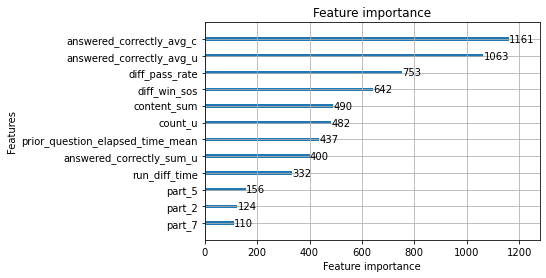

In [115]:
print('auc:', roc_auc_score(y_va, model.predict(valid_2[FEATS])))
_ = lgb.plot_importance(model)

f = open("fil_na_valid.pkl","wb")
pickle.dump(fil_na_valid,f)
f.close()

In [78]:
import pickle
def save_model(model,model_name):

    pkl_filename = "%s.pkl"  % (model_name)
    print(pkl_filename)
    with open(pkl_filename, 'wb') as file:  
        pickle.dump(model, file)

In [79]:
model_name='/home/jupyter/' + 'lgbm_11_25_20' 
save_model(model,model_name)

/home/jupyter/lgbm_11_25_20.pkl
